In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

# SKLEARN modules
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from scipy.interpolate import griddata

import sys
sys.path.append('../')
from src.utils import (
    load_dataset,
    create_folds,
    standardize_data,
    generate_data,
    create_weight_matrix,
)

from Datasets.spatial_dataset import SpatialDataset

In [2]:
# Print out the args
data_dir = "../data/boston/"
city = "boston"
window_size = 25
use_coords = False
ndvi_ls = 16
albedo_ls = 7
l2_alpha = 0.1 

In [3]:
data = load_dataset(data_dir, window_size, city)

In [4]:
print(data.coords)

[[ 483  772]
 [ 483  773]
 [ 483  774]
 ...
 [2871  644]
 [2872  640]
 [2872  641]]


In [5]:
idx = range(len(data.coords))
X, y = generate_data(data, idx, ndvi_ls, albedo_ls, window_size, False)

In [6]:
# Now, we need to standardize the data for the final fit
x_shift = X.min(axis=0)
x_scale = X.max(axis=0) - X.min(axis=0)

# Add in a small number 1e-8 to prevent divide by zero errors
x_train = (X - x_shift) / (x_scale + 1e-16)

# Standardize the labels
y_mean = y.mean()
y_std = y.std()

y_train = (y - y_mean) / (y_std)

# Round 1

In [7]:
lm = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, y_train)
lm.coef_

array([-0.44265678, -0.17886872, -0.63603277, -0.46526224,  1.0820025 ,
        1.0078993 , -1.09039724, -0.62155265, -1.27695948, -1.76268038,
       -0.10760816,  0.46295477,  0.        , -1.10692397,  1.64109349,
       -0.18075901, -0.46366424,  0.16433648, -0.19087813])

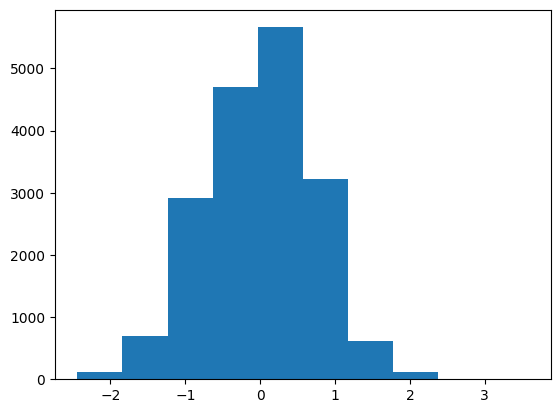

In [8]:
pred = lm.predict(x_train)
plt.hist(y_train - pred)
plt.show()

In [9]:
coords = data.coords

residuals = y_train - pred

N = 1000
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [10]:
from scipy.optimize import minimize

def optimizer(obj_func, initial_theta, bounds):
    opt_res =  minimize(obj_func, initial_theta, method='L-BFGS-B', bounds=bounds, jac=True, options = {'maxiter':1000})    
    return opt_res.x, opt_res.fun

In [11]:
kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.1, random_state=100, n_restarts_optimizer=10)

gpr.fit(sample_points, sample_residuals)

GaussianProcessRegressor(alpha=0.1,
                         kernel=0.707**2 * Matern(length_scale=115, nu=0.5) + 0.000548**2 * DotProduct(sigma_0=0.1),
                         n_restarts_optimizer=10, random_state=100)

In [12]:
x = np.arange(0, data.ndvi.shape[0])
y = np.arange(0, data.ndvi.shape[1])

# Get the meshgrid of the points
(x_grid, y_grid) = np.meshgrid(x, y)

# Downsample the points, by only getting every 10th point
ds = 10
x_downsample = x_grid[::ds, ::ds]
y_downsample = y_grid[::ds, ::ds]

# Stack the x and y coordinates
all_coords = np.vstack((x_downsample.flatten(), y_downsample.flatten())).T

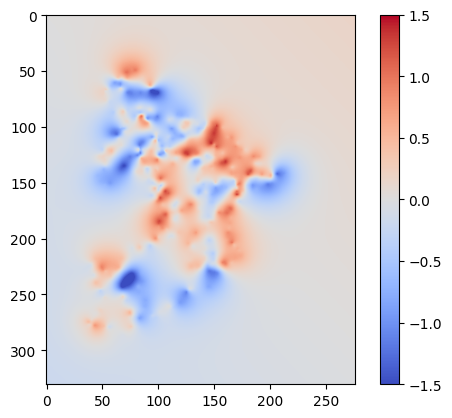

In [13]:
preds = gpr.predict(all_coords)
plt.imshow(preds.reshape(x_downsample.shape).T, cmap='coolwarm', vmin=-1.5, vmax=1.5)
plt.colorbar()

# Round 2

In [14]:
U = gpr.predict(coords)
lm2 = Ridge(alpha=l2_alpha, fit_intercept=False).fit(x_train, y_train - U)
lm2.coef_

array([-0.35492771, -0.36111498, -0.6751283 , -0.61152554,  0.97388847,
        0.90715092, -1.4101786 , -0.81935868, -1.04115081, -1.86990795,
        0.09275255,  0.52592538,  0.        , -1.25924481,  1.30020386,
       -0.1195278 , -0.17395978, -0.02068729, -0.15507154])

In [15]:
# print out r2 score
pred = lm2.predict(x_train) #+ U
# pred_val = lm2.predict(x_val)
# print("R2 score", r2_score(y_val, pred_val ))
print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.4764812407306819


In [16]:
residuals = y_train - lm2.predict(x_train)
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [17]:
kernel = (kernels.ConstantKernel(0.5, 'fixed')*kernels.Matern(length_scale=115, nu=0.5, length_scale_bounds='fixed')+ kernels.ConstantKernel(3e-7, 'fixed')*kernels.DotProduct(0.1, 'fixed'))
gpr = GaussianProcessRegressor(kernel = kernel, alpha=0.1, random_state=100, n_restarts_optimizer=10)

gpr.fit(sample_points, sample_residuals)

GaussianProcessRegressor(alpha=0.1,
                         kernel=0.707**2 * Matern(length_scale=115, nu=0.5) + 0.000548**2 * DotProduct(sigma_0=0.1),
                         n_restarts_optimizer=10, random_state=100)

In [18]:
U = gpr.predict(coords)

# Round 3

In [19]:
lm3 = Ridge(alpha=l2_alpha).fit(x_train, y_train - U)
lm3.coef_

array([-1.01983426e-03, -2.59066564e-01, -2.80537578e-01, -2.36299331e-01,
        1.54498583e+00,  1.06978549e+00, -1.19911531e+00, -9.55172831e-01,
       -1.03391566e+00, -1.65547293e+00,  3.88424331e-01,  3.61487978e-01,
        0.00000000e+00, -7.28275638e-01,  1.18192593e+00, -1.43499525e-01,
        1.20779362e-01,  9.36516974e-03, -2.21861493e-01])

In [20]:
# print out r2 score
pred = lm3.predict(x_train) + U

print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.9182125177312502


In [21]:
residuals = y_train - lm3.predict(x_train)

In [22]:
sample_idx = np.random.choice(np.arange(coords.shape[0]), N, replace=False)
sample_points = coords[sample_idx, :]
sample_residuals = residuals[sample_idx]

In [23]:
kernel = kernels.ConstantKernel(0.5, constant_value_bounds='fixed')*kernels.Matern(length_scale=150, nu=0.5, length_scale_bounds='fixed') + kernels.DotProduct(0.001, sigma_0_bounds='fixed') #+ kernels.WhiteKernel(noise_level=0.1, noise_level_bounds='fixed')
gpr = GaussianProcessRegressor(kernel = kernel, optimizer=optimizer, n_restarts_optimizer=10, random_state=100)

gpr.fit(sample_points, sample_residuals)

GaussianProcessRegressor(kernel=0.707**2 * Matern(length_scale=150, nu=0.5) + DotProduct(sigma_0=0.001),
                         n_restarts_optimizer=10,
                         optimizer=<function optimizer at 0x00000263CB970720>,
                         random_state=100)

In [24]:
U = gpr.predict(coords)

# Round 4

In [25]:
lm4 = Ridge(alpha=l2_alpha).fit(x_train, y_train - U)
lm4.coef_

array([-0.15650017, -0.3916411 , -0.23921236, -0.21440759,  1.49425789,
        0.8837916 , -0.93596353, -0.69767004, -1.01166021, -1.60122386,
        0.54570669,  0.21892477,  0.        , -0.8459367 ,  1.07890682,
       -0.16728048,  0.08840608, -0.10445267, -0.12935749])

In [26]:
# print out r2 score
pred = lm4.predict(x_train) + U

print("R2 score: ", r2_score(y_train, pred))

R2 score:  0.9235647192943716


In [27]:
lm4.intercept_

-0.5905233701116716

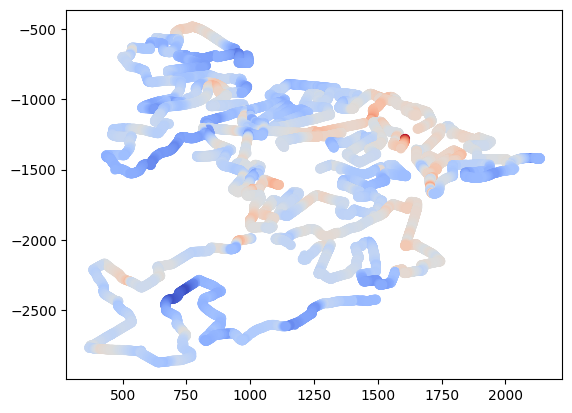

In [28]:
plt.scatter(coords[:, 1], -coords[:, 0], c=U, cmap='coolwarm')

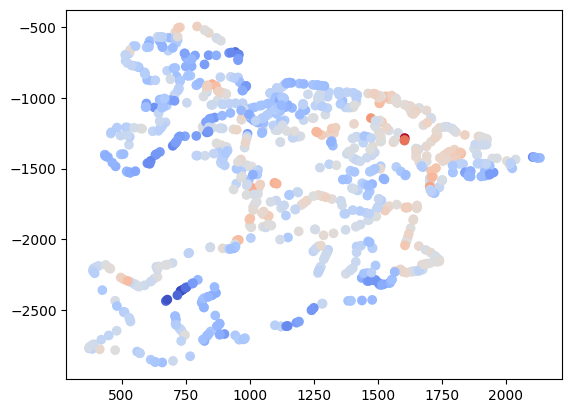

In [29]:
plt.scatter(sample_points[:, 1], -sample_points[:, 0], c=sample_residuals, cmap='coolwarm')